In [1]:
# regular imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import env
import seaborn as sns
import wrangle as wr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split

In [2]:
# from our acquire.py:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
sql_query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''
    
def get_zillow_data():
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop(columns='id')
    return df

In [51]:
df = get_zillow_data()

In [52]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,...,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,...,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,...,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,...,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,...,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   airconditioningtypeid         13615 non-null  float64
 2   architecturalstyletypeid      70 non-null     float64
 3   basementsqft                  47 non-null     float64
 4   bathroomcnt                   52319 non-null  float64
 5   bedroomcnt                    52319 non-null  float64
 6   buildingclasstypeid           0 non-null      object 
 7   buildingqualitytypeid         33654 non-null  float64
 8   calculatedbathnbr             52184 non-null  float64
 9   decktypeid                    389 non-null    float64
 10  finishedfloor1squarefeet      4371 non-null   float64
 11  calculatedfinishedsquarefeet  52238 non-null  float64
 12  finishedsquarefeet12          52073 non-null  float64
 13  f

In [54]:
df.heatingorsystemtypeid.value_counts()

 2.00    20689
 7.00    12526
 6.00      517
20.00       85
13.00       16
 1.00        7
18.00        6
10.00        2
24.00        1
Name: heatingorsystemtypeid, dtype: int64

In [55]:
df.heatingorsystemtypeid.isna().value_counts()

False    33849
True     18470
Name: heatingorsystemtypeid, dtype: int64

In [56]:
df.heatingorsystemdesc.value_counts()

Central       20689
Floor/Wall    12526
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [57]:
df.heatingorsystemdesc.isna().value_counts()

False    33849
True     18470
Name: heatingorsystemdesc, dtype: int64

In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"52,319.00","12,996,817.91","3,350,951.35","10,711,855.00","11,510,167.50","12,578,254.00","14,130,361.00","167,687,839.00"
airconditioningtypeid,"13,615.00",2.44,3.85,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"
bathroomcnt,"52,319.00",2.30,1.02,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"52,319.00",3.30,0.95,0.00,3.00,3.00,4.00,14.00
buildingqualitytypeid,"33,654.00",6.26,1.72,1.00,5.00,6.00,8.00,12.00
calculatedbathnbr,"52,184.00",2.31,1.02,1.00,2.00,2.00,3.00,18.00
decktypeid,389.00,66.00,0.00,66.00,66.00,66.00,66.00,66.00
finishedfloor1squarefeet,"4,371.00","1,546.29",675.34,184.00,"1,151.00","1,410.00","1,760.00","6,912.00"


(-1.0, 1.0)

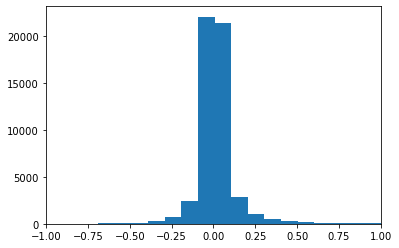

In [59]:
#Distribution of target variable
plt.hist(x=df['logerror'], bins=100)
plt.xlim(-1, 1)

In [60]:
print(f'r0ws: {df.shape[0]}')
print(f'co1umns: {df.shape[1]}')

r0ws: 52319
co1umns: 67


In [61]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())

parcelid
14297519    1
17237669    1
11839030    1
17148095    1
11311690    1
           ..
14138000    1
12026029    1
14212835    1
12213446    1
12826780    1
Name: parcelid, Length: 52319, dtype: int64
airconditioningtypeid
 1.00    11873
13.00     1567
 5.00      159
11.00       16
Name: airconditioningtypeid, dtype: int64
architecturalstyletypeid
 7.00    62
 3.00     3
 2.00     2
21.00     2
 8.00     1
Name: architecturalstyletypeid, dtype: int64
basementsqft
  900.00    2
  640.00    2
  100.00    2
  515.00    2
  273.00    2
  912.00    2
  314.00    1
  819.00    1
1,809.00    1
  604.00    1
  126.00    1
  588.00    1
  786.00    1
  669.00    1
  800.00    1
  396.00    1
  112.00    1
  645.00    1
  384.00    1
1,969.00    1
  252.00    1
  600.00    1
1,218.00    1
  280.00    1
  300.00    1
  224.00    1
  512.00    1
  380.00    1
  204.00    1
  200.00    1
   90.00    1
3,112.00    1
  405.00    1
1,252.00    1
  254.00    1
3,560.00    1
  352.00    1
  168.00

Nulls By Column

Sure, using built in methods is easy enough. But what about getting our nulls by column and nulls by row?

Let's look at nulls by column. Let's start by using .isnull():

In [62]:
df.isnull().head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
1,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
2,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
3,False,True,True,True,False,False,True,False,False,True,...,False,False,False,True,True,True,False,False,True,True
4,False,False,True,True,False,False,True,False,False,True,...,False,False,False,False,True,True,False,False,True,True


In [63]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,...,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,...,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,...,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,...,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,...,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [64]:
df.isnull().sum()[:50]

parcelid                            0
airconditioningtypeid           38704
architecturalstyletypeid        52249
basementsqft                    52272
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             52319
buildingqualitytypeid           18665
calculatedbathnbr                 135
decktypeid                      51930
finishedfloor1squarefeet        47948
calculatedfinishedsquarefeet       81
finishedsquarefeet12              246
finishedsquarefeet13            52319
finishedsquarefeet15            52319
finishedsquarefeet50            47948
finishedsquarefeet6             52154
fips                                0
fireplacecnt                    45086
fullbathcnt                       135
garagecarcnt                    34335
garagetotalsqft                 34335
hashottuborspa                  50805
heatingorsystemtypeid           18470
latitude                            0
longitude                           0
lotsizesquar

In [65]:
df.shape[0] # Number of rows

52319

In [66]:
(df.isnull().sum()/df.shape[0]*100)[:] # Percentage of nulls in each column

parcelid                                   0.00
airconditioningtypeid                     73.98
architecturalstyletypeid                  99.87
basementsqft                              99.91
bathroomcnt                                0.00
                                   ...         
buildingclassdesc                        100.00
heatingorsystemdesc                       35.30
propertylandusedesc                        0.00
storydesc                                 99.91
typeconstructiondesc                      99.85
Length: 67, dtype: float64

In [67]:
nulls_col = pd.DataFrame({'num_rows_missing': df.isnull().sum(), 
              'percent_rows_missing': (df.isnull().sum() / df.shape[0] * 100)})

nulls_col.sort_values(by='num_rows_missing', ascending=False).head(60)

,num_rows_missing,percent_rows_missing
finishedsquarefeet13,52319,100.00
buildingclasstypeid,52319,100.00
buildingclassdesc,52319,100.00
finishedsquarefeet15,52319,100.00
basementsqft,52272,99.91
storydesc,52272,99.91
storytypeid,52272,99.91
yardbuildingsqft26,52256,99.88
architecturalstyletypeid,52249,99.87
architecturalstyledesc,52249,99.87


In [68]:
df.poolcnt.value_counts()

1.00    11077
Name: poolcnt, dtype: int64

### nulls_by_col function

In [69]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing.sort_values(by='num_rows_missing', ascending=False)

In [70]:
nulls_by_col(df)

,num_rows_missing,percent_rows_missing
finishedsquarefeet13,52319,100.00
buildingclasstypeid,52319,100.00
buildingclassdesc,52319,100.00
finishedsquarefeet15,52319,100.00
basementsqft,52272,99.91
...,...,...
latitude,0,0.00
fips,0,0.00
bedroomcnt,0,0.00
bathroomcnt,0,0.00


Nulls by Row



In [71]:
# look at the number/percent of nulls in each row
df.isnull().sum(axis=1)

0        36
1        33
2        34
3        32
4        29
         ..
52314    34
52315    33
52316    32
52317    32
52318    34
Length: 52319, dtype: int64

In [72]:
#both NaN and None are considered as null
df.head(1)[df.head(1).isna()]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,NaN,None,None


In [73]:
#into a percentage:
df.isnull().sum(axis=1) / df.shape[1] * 100

0                      53.73
1                      49.25
2                      50.75
3                      47.76
4                      43.28
                ...         
52314                  50.75
52315                  49.25
52316                  47.76
52317                  47.76
52318                  50.75
Length: 52319, dtype: float64

In [74]:
nulls_row = pd.DataFrame({'num_cols_missing': df.isnull().sum(axis=1),
              'percent_cols_missing': df.isnull().sum(axis=1)/df.shape[1]*100})

nulls_row

,num_cols_missing,percent_cols_missing
0,36,53.73
1,33,49.25
2,34,50.75
3,32,47.76
4,29,43.28
...,...,...
52314,34,50.75
52315,33,49.25
52316,32,47.76
52317,32,47.76


In [75]:
#if we wanted parcel id back in
# nulls_row = df.merge(nulls_row,
#                         left_index=True,
#                         right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]

# nulls_row

In [76]:
nulls_row.sort_values(by='num_cols_missing', ascending=False)

,num_cols_missing,percent_cols_missing
28006,48,71.64
8954,48,71.64
41347,47,70.15
13356,46,68.66
21989,45,67.16
...,...,...
44684,24,35.82
83,24,35.82
37444,24,35.82
39391,23,34.33


### nulls_by_row function

In [77]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})
#     rows_missing = df.merge(rows_missing,
#                         left_index=True,
#                         right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [78]:
nulls_by_row(df)

,num_cols_missing,percent_cols_missing
28006,48,71.64
8954,48,71.64
41347,47,70.15
13356,46,68.66
21989,45,67.16
...,...,...
44684,24,35.82
83,24,35.82
37444,24,35.82
39391,23,34.33


### summarize function

In [79]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    '''
    print('SUMMARY REPORT')
    print('=====================================================\n\n')
    print('Dataframe head: ')
    print(df.head(3))
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts(), '\n')
        else:
            print(df[col].value_counts(bins=10, sort=False), '\n')
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')

In [80]:
summarize(df)

SUMMARY REPORT


Dataframe head: 
   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   

           bathroomcnt           bedroomcnt buildingclasstypeid  \
0                 3.50                 4.00                None   
1                 1.00                 2.00                None   
2                 2.00                 3.00                None   

   buildingqualitytypeid    calculatedbathnbr  decktypeid  ...  \
0                    NaN                 3.50         NaN  ...   
1                    NaN                 1.00         NaN  ...   
2                    NaN                 2.00         NaN  ...   

    censustractandblock             logerror  transactiondate  \
0 60,590,630,072,012.00                 0.03       201

(1.9800000000000002, 3.9]     5
(3.9, 5.8]                    0
(5.8, 7.7]                   62
(7.7, 9.6]                    1
(9.6, 11.5]                   0
(11.5, 13.4]                  0
(13.4, 15.3]                  0
(15.3, 17.2]                  0
(17.2, 19.1]                  0
(19.1, 21.0]                  2
Name: architecturalstyletypeid, dtype: int64 

(34.477000000000004, 390.2]    20
(390.2, 742.4]                 13
(742.4, 1094.6]                 7
(1094.6, 1446.8]                3
(1446.8, 1799.0]                0
(1799.0, 2151.2]                2
(2151.2, 2503.4]                0
(2503.4, 2855.6]                0
(2855.6, 3207.8]                1
(3207.8, 3560.0]                1
Name: basementsqft, dtype: int64 

(-0.019, 1.8]    10494
(1.8, 3.6]       37337
(3.6, 5.4]        3714
(5.4, 7.2]         679
(7.2, 9.0]          85
(9.0, 10.8]          5
(10.8, 12.6]         3
(12.6, 14.4]         1
(14.4, 16.2]         0
(16.2, 18.0]         1
Name: bathroomcnt, dtype: in

(-48791.03799999999, 4895364.7]    52212
(4895364.7, 9790568.4]                86
(9790568.4, 14685772.1]               13
(14685772.1, 19580975.8]               5
(19580975.8, 24476179.5]               1
(24476179.5, 29371383.2]               0
(29371383.2, 34266586.9]               0
(34266586.9, 39161790.6]               0
(39161790.6, 44056994.3]               0
(44056994.3, 48952198.0]               1
Name: landtaxvaluedollarcnt, dtype: int64 

(-537.411, 58708.192]       52117
(58708.192, 117367.204]       165
(117367.204, 176026.216]       19
(176026.216, 234685.228]        9
(234685.228, 293344.24]         4
(293344.24, 352003.252]         0
(352003.252, 410662.264]        0
(410662.264, 469321.276]        0
(469321.276, 527980.288]        0
(527980.288, 586639.3]          1
Name: taxamount, dtype: int64 

Y    2068
Name: taxdelinquencyflag, dtype: int64 

(3.904, 13.5]     384
(13.5, 23.0]     1683
(23.0, 32.5]        0
(32.5, 42.0]        0
(42.0, 51.5]        0
(51.5, 61.0] 

In [81]:
#remove columns
def remove_columns(df, cols_to_remove):
    df = df.drop(columns = cols_to_remove)
    return df

In [82]:
#columns to remove, no use in model, mostly, null, repreated features
#cols_to_remove = ['buildingqualitytypeid','calculatedbathnbr','finishedsquarefeet12','fullbathcnt','heatingorsystemtypeid','roomcnt','unitcnt','propertyzoningdesc']

In [83]:
# df = remove_columns(df, cols_to_remove)

In [84]:
#handle missing values
def handle_missing_values(df, prop_required_columns =0.87, prop_required_row=0.87):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    #axis 1 : drop columns that have missing values
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns),0))
    #axis 0 : drop rows that have missing values
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [85]:
handle_missing_values(df, prop_required_columns =0.87, prop_required_row=0.87)


,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,14297519,3.50,4.00,3.50,"3,100.00","3,100.00","6,059.00",3.00,"33,634,931.00","-117,869,207.00",...,"1,998.00","485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72","60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential
1,17052889,1.00,2.00,1.00,"1,465.00","1,465.00","6,111.00",1.00,"34,449,266.00","-119,281,531.00",...,"1,967.00","88,000.00","464,000.00","2,016.00","376,000.00","5,672.48","61,110,010,023,006.00",0.06,2017-01-01,Single Family Residential
2,14186244,2.00,3.00,2.00,"1,243.00","1,243.00","6,059.00",2.00,"33,886,168.00","-117,823,170.00",...,"1,962.00","85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",0.01,2017-01-01,Single Family Residential
3,12177905,3.00,4.00,3.00,"2,376.00","2,376.00","6,037.00",3.00,"34,245,180.00","-118,240,722.00",...,"1,970.00","108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",-0.10,2017-01-01,Single Family Residential
4,12095076,3.00,4.00,3.00,"2,962.00","2,962.00","6,037.00",3.00,"34,145,202.00","-118,179,824.00",...,"1,950.00","276,684.00","773,303.00","2,016.00","496,619.00","9,516.26","60,374,608,001,014.00",-0.00,2017-01-01,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,12412492,2.00,4.00,2.00,"1,633.00","1,633.00","6,037.00",2.00,"33,870,815.00","-118,070,858.00",...,"1,962.00","125,466.00","346,534.00","2,016.00","221,068.00","4,175.08","60,375,548,022,001.00",0.00,2017-09-19,Single Family Residential
52315,11000655,2.00,2.00,2.00,"1,286.00","1,286.00","6,037.00",2.00,"34,245,368.00","-118,282,383.00",...,"1,940.00","70,917.00","354,621.00","2,016.00","283,704.00","4,478.43","60,371,014,003,002.00",0.02,2017-09-20,Single Family Residential
52316,17239384,2.00,4.00,2.00,"1,612.00","1,612.00","6,111.00",2.00,"34,300,140.00","-118,706,327.00",...,"1,964.00","50,683.00","67,205.00","2,016.00","16,522.00","1,107.48","61,110,084,022,016.00",0.01,2017-09-21,Single Family Residential
52317,12773139,1.00,3.00,1.00,"1,032.00","1,032.00","6,037.00",1.00,"34,040,895.00","-118,038,169.00",...,"1,954.00","32,797.00","49,546.00","2,016.00","16,749.00",876.43,"60,374,338,022,005.00",0.04,2017-09-21,Single Family Residential


In [86]:
# combining everything in a cleaning function:
def data_prep(df, cols_to_remove=[], prop_required_column=0.87, prop_required_row=0.87):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [87]:
df = data_prep(df, cols_to_remove = ['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'assessmentyear',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock',
 'architecturalstyledesc',
 'buildingclassdesc',
 'propertylandusedesc',
 'regionidneighborhood',                                   
 'storydesc',
 'typeconstructiondesc'], prop_required_column=0.15, prop_required_row=0.15)

In [88]:
df.columns.values.tolist()

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'fullbathcnt',
 'garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate',
 'airconditioningdesc',
 'heatingorsystemdesc']

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   bathroomcnt                   52319 non-null  float64
 2   bedroomcnt                    52319 non-null  float64
 3   calculatedfinishedsquarefeet  52238 non-null  float64
 4   fips                          52319 non-null  float64
 5   fullbathcnt                   52184 non-null  float64
 6   garagecarcnt                  17984 non-null  float64
 7   latitude                      52319 non-null  float64
 8   longitude                     52319 non-null  float64
 9   lotsizesquarefeet             51953 non-null  float64
 10  poolcnt                       11077 non-null  float64
 11  regionidcity                  51283 non-null  float64
 12  regionidcounty                52319 non-null  float64
 13  r

In [98]:
df = clean_and_prep(df)

In [99]:
df.isna().sum()

parcelid                               0
bathrooms                              0
bedrooms                               0
sqft                                   0
fips                                   0
fullbathcnt                            0
garagecarcnt                           0
latitude                               0
longitude                              0
lotsizesquarefeet                      0
poolcnt                                0
regionidcity                           0
regionidcounty                         0
regionidzip                            0
yearbuilt                              0
structuretaxvaluedollarcnt             0
home_value                             0
landtaxvaluedollarcnt                  0
taxamount                              0
logerror                               0
transactiondate                        0
airconditioningdesc                    0
heatingorsystemdesc                    0
home_value_structure_tax_difference    0
hvs_pct         

In [104]:
def optimize_types(df):
# Convert some columns to integers, optimize types
# # fips, yearbuilt, and bedrooms can be integers   
    df["fips"] = df["fips"].astype(str)
    df["yearbuilt"] = df["yearbuilt"].astype(int)
    df["bedrooms"] = df["bedrooms"].astype(int)
    df["bathrooms"] = df["bathrooms"].astype(int)
    df["home_value"] = df["home_value"].astype(int)
    df["garagecarcnt"] = df["garagecarcnt"].astype(int)
    df["poolcnt"] = df["poolcnt"].astype(int)
#   df["heatingorsystemdesc"] = df["heatingorsystemdesc"].astype(int)
    df["airconditioning_encoded"] = df["airconditioning_encoded"].astype(int)
    df["sqft"] = df["sqft"].astype(int)
    return df

In [97]:
def clean_and_prep(df):
##rename some columns for ease of use
    df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "sqft","taxvaluedollarcnt": "home_value"})
    
#remove homes with zero beds
    df = df[df.bedrooms != 0]
    
##filled null/Nonetype with 'None' or '0'
    df.heatingorsystemdesc = df.heatingorsystemdesc.fillna('None')
    df.airconditioningdesc = df.airconditioningdesc.fillna('None')
    df.poolcnt = df.poolcnt.fillna('0')
    df.garagecarcnt = df.garagecarcnt.fillna('0')
    
#feature engineering
    df['home_value_structure_tax_difference'] = (df['home_value']-df['structuretaxvaluedollarcnt'])
    df['hvs_pct'] = (df['home_value_structure_tax_difference']/df['home_value'])
    df['taxrate'] = (df['taxamount']/df['home_value'])
    df['age'] = 2017 - df.yearbuilt
    df['cost_per_sqft'] = (df['home_value']/df['sqft']).round(2)
    df['sqft_room_ratio'] = (df['sqft']/(df['bedrooms']+df['bathrooms'])).round(2)
    mapping = {"None" : "0",
                     "Central" : "2",
                     "Yes" : "1",
                     "Wall Unit" : "1",
                     }
    df['airconditioning_encoded'] = df['airconditioningdesc'].map(mapping)

#impute nulls with tax rate mean times home value
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(df['home_value']*df['hvs_pct'].mean())
    
#impute 4 missing values for taxamount using mean taxrate of feature engineering
    df.taxamount = df.taxamount.fillna(df['home_value']*df['taxrate'].mean())
    
#impute nulls with regionidcity mode of 12447
    df['regionidcity'] = df.regionidcity.fillna(12447)
    
#impute missing values with below
    df.home_value_structure_tax_difference = df.home_value_structure_tax_difference.fillna(df['home_value']-df['structuretaxvaluedollarcnt'])
    
#impute missing values with below
    df.hvs_pct = df.hvs_pct.fillna(df['home_value_structure_tax_difference']/df['home_value'])
    
#impute nulls with mean year built
    df.yearbuilt = df.yearbuilt.fillna(df['yearbuilt'].mean())
    
#impute nulls with mode of regionidzip
    df.regionidzip = df.regionidzip.fillna(df.regionidzip.mode())
    
##replace nulls with median lot size
    df.lotsizesquarefeet = df.lotsizesquarefeet.fillna(df.lotsizesquarefeet.median())
    
##impute fullbathcnt with value from df.bathrooms
    df.fullbathcnt = df.fullbathcnt.fillna(df.bathrooms)                                                   
                                                       
##drop remaining handful of nulls
    df = df.dropna()                                                   
    return df

In [187]:
# feature engineering luxuryscore will be counts for pool, garage, ac, number of bathrooms and bedrooms
df['luxury_score'] = (df['poolcnt']+df['garagecarcnt']+df['bedrooms']+df['bathrooms']+df['airconditioning_encoded'])

#feature engineering luxury score/age*sqft
df['luxury_sqft_per_age']= (df['luxury_score']*df['sqft']/df['age'])

#feature engineering
df['quarter'] = pd.PeriodIndex(df.transactiondate, freq='Q')
df['quarter']=df['quarter'].astype(str)

In [179]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

In [190]:
df = get_counties()
df.head().T

In [184]:
def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathrooms <= 7]
    
    df = df[df.bedrooms <= 6]

    df = df[df.home_value < 3_000_000]

    df.drop(df.loc[df.sqft >10000].index, inplace=True)

    df.drop(df.loc[df['bedrooms']==0].index, inplace=True)
    
    df.drop(df.loc[df['bathrooms']==0].index, inplace=True)

    return df

In [185]:
handle_outliers(df)

,parcelid,bathrooms,bedrooms,sqft,fips,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,...,taxrate,age,cost_per_sqft,sqft_room_ratio,airconditioning_encoded,luxury_score,luxury_sqft_per_age,LA,Orange,Ventura
0,14297519,3,4,3100,6059.0,3.00,2,"33,634,931.00","-117,869,207.00","4,506.00",...,0.01,19.00,330.09,413.33,0,9,"1,468.42",0,1,0
1,17052889,1,2,1465,6111.0,1.00,1,"34,449,266.00","-119,281,531.00","12,647.00",...,0.01,50.00,316.72,488.33,0,4,117.20,0,0,1
2,14186244,2,3,1243,6059.0,2.00,2,"33,886,168.00","-117,823,170.00","8,432.00",...,0.01,55.00,454.37,248.60,0,8,180.80,0,1,0
3,12177905,3,4,2376,6037.0,3.00,0,"34,245,180.00","-118,240,722.00","13,038.00",...,0.01,47.00,61.09,339.43,0,8,404.43,1,0,0
4,12095076,3,4,2962,6037.0,3.00,0,"34,145,202.00","-118,179,824.00","63,000.00",...,0.01,67.00,261.07,423.14,2,10,442.09,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,12412492,2,4,1633,6037.0,2.00,0,"33,870,815.00","-118,070,858.00","4,630.00",...,0.01,55.00,212.21,272.17,0,6,178.15,1,0,0
52315,11000655,2,2,1286,6037.0,2.00,0,"34,245,368.00","-118,282,383.00","47,405.00",...,0.01,77.00,275.76,321.50,0,4,66.81,1,0,0
52316,17239384,2,4,1612,6111.0,2.00,2,"34,300,140.00","-118,706,327.00","12,105.00",...,0.02,53.00,41.69,268.67,0,8,243.32,0,0,1
52317,12773139,1,3,1032,6037.0,1.00,0,"34,040,895.00","-118,038,169.00","5,074.00",...,0.02,63.00,48.01,258.00,2,6,98.29,1,0,0


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52119 entries, 0 to 52318
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype        
---  ------                               --------------  -----        
 0   parcelid                             52119 non-null  int64        
 1   bathrooms                            52119 non-null  int32        
 2   bedrooms                             52119 non-null  int32        
 3   sqft                                 52119 non-null  int32        
 4   fips                                 52119 non-null  object       
 5   fullbathcnt                          52119 non-null  float64      
 6   garagecarcnt                         52119 non-null  int32        
 7   latitude                             52119 non-null  float64      
 8   longitude                            52119 non-null  float64      
 9   lotsizesquarefeet                    52119 non-null  float64      
 10  poolcnt               

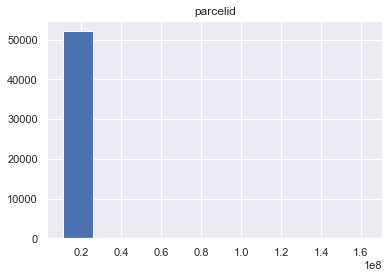

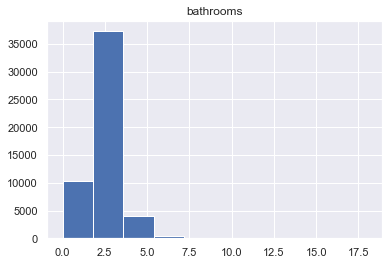

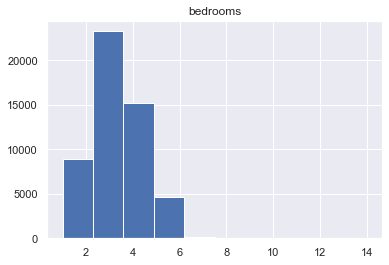

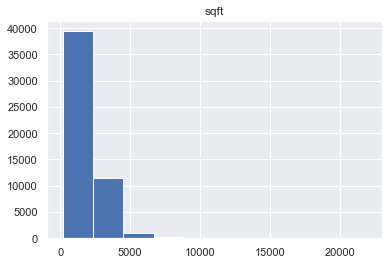

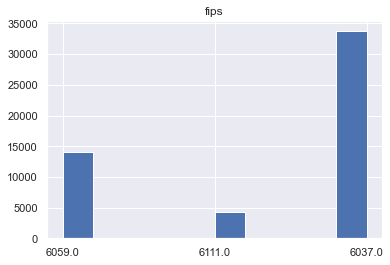

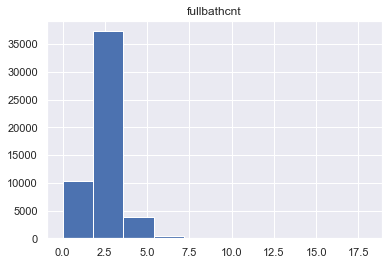

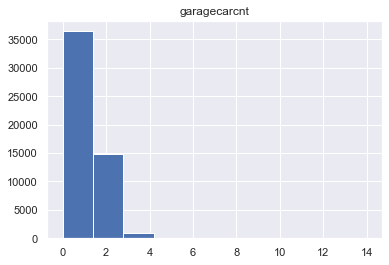

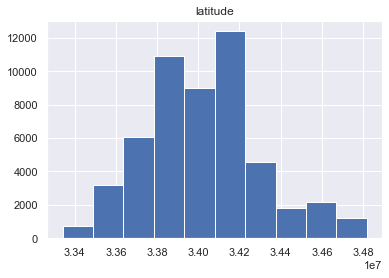

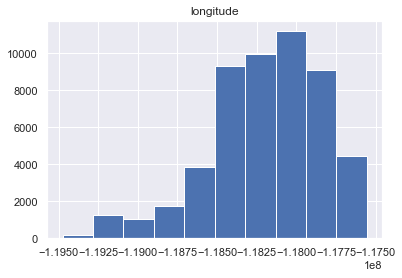

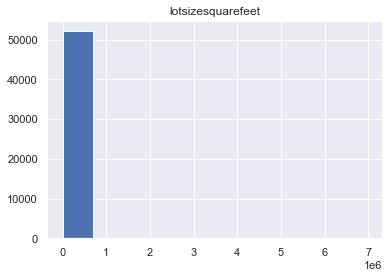

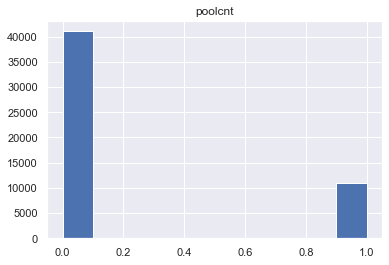

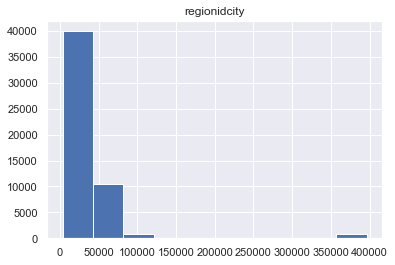

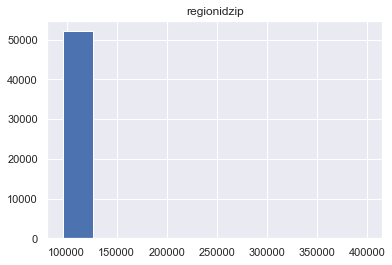

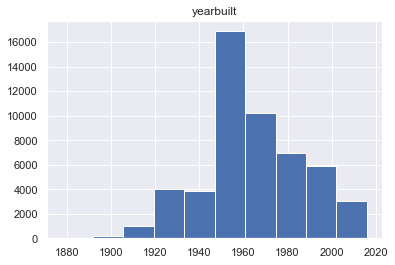

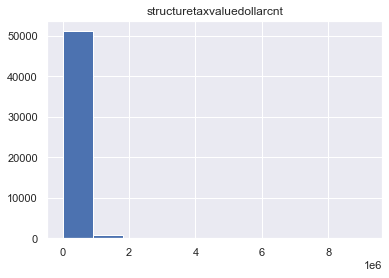

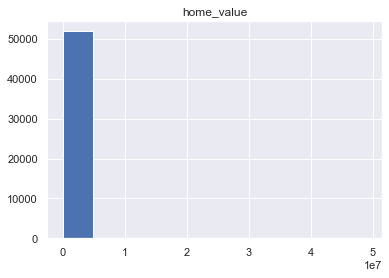

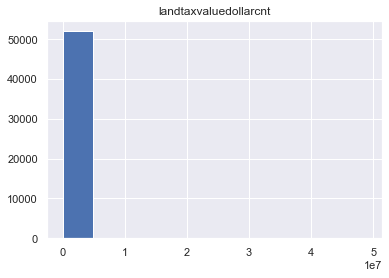

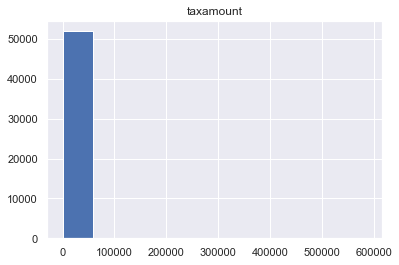

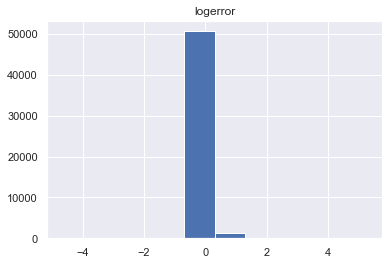

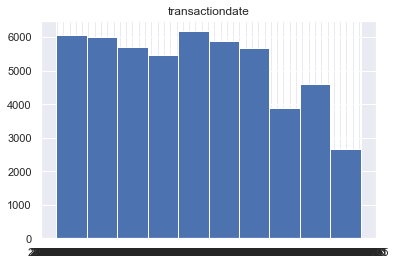

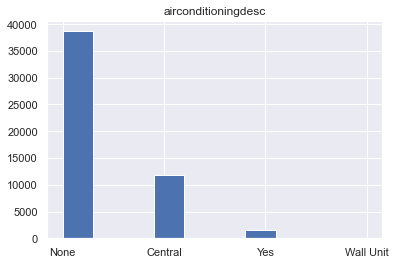

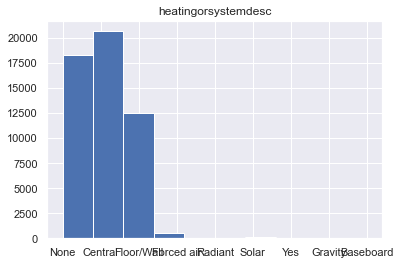

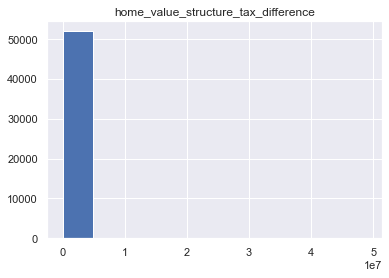

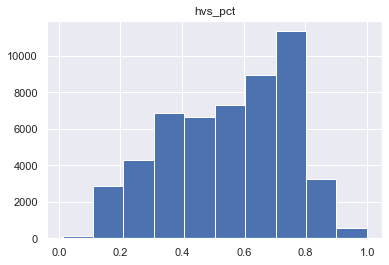

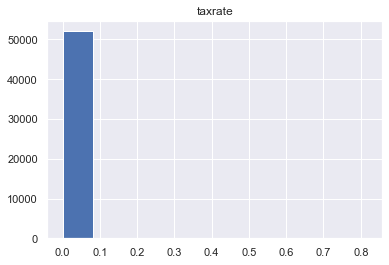

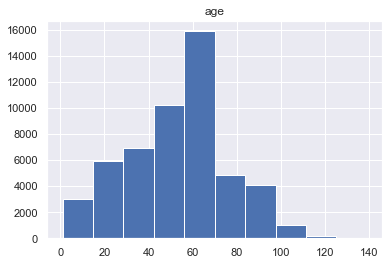

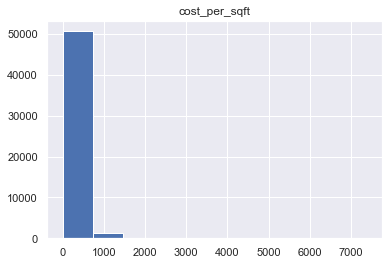

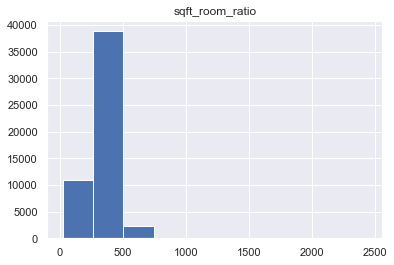

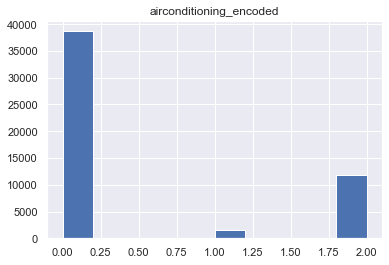

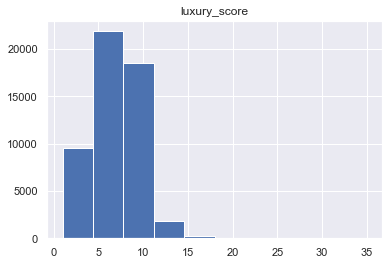

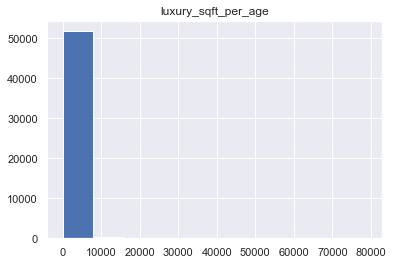

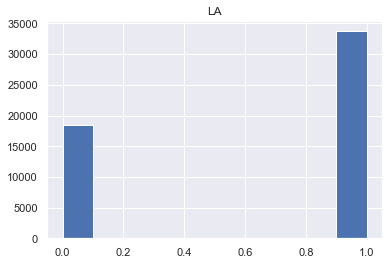

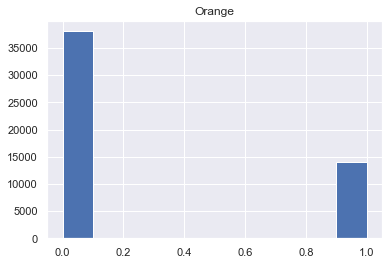

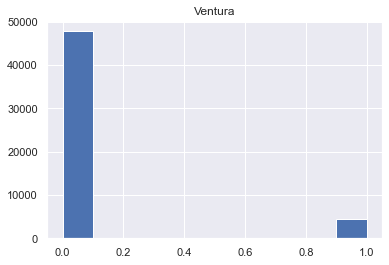

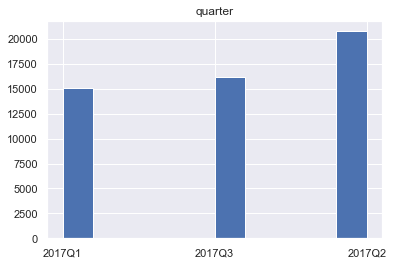

In [197]:
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [196]:
# df.quarter=df.quarter.astype(str)
# df.info()

In [198]:
def split(df, target_var):
    '''
    This function takes in the dataframe and target variable name as arguments and then
    splits the dataframe into train (56%), validate (24%), & test (20%)
    It will return a list containing the following dataframes: train (for exploration), 
    X_train, X_validate, X_test, y_train, y_validate, y_test
    '''
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

    partitions = [train, X_train, X_validate, X_test, y_train, y_validate, y_test]
    return partitions

In [199]:
partitions = split(df, target_var='logerror')

In [200]:
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
partitions[0] = train

In [201]:
train.logerror_bins.value_counts()

(-0.05, 0.05]    18941
(0.05, 0.2]       4741
(-0.2, -0.05]     3518
(0.2, 4.0]        1320
(-5.0, -0.2]       665
Name: logerror_bins, dtype: int64

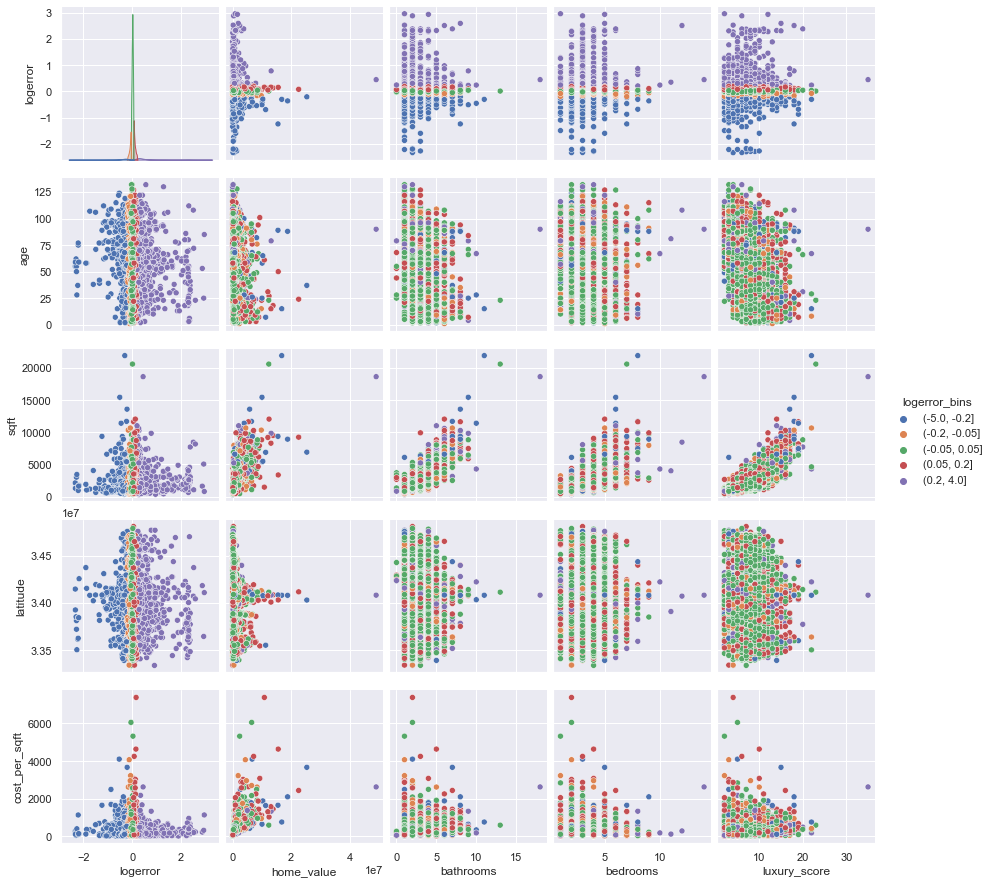

In [206]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'home_value', 'bathrooms', 'bedrooms', 
                       'luxury_score'],
             y_vars = ['logerror', 'age', 'sqft', 'latitude', 'cost_per_sqft'])

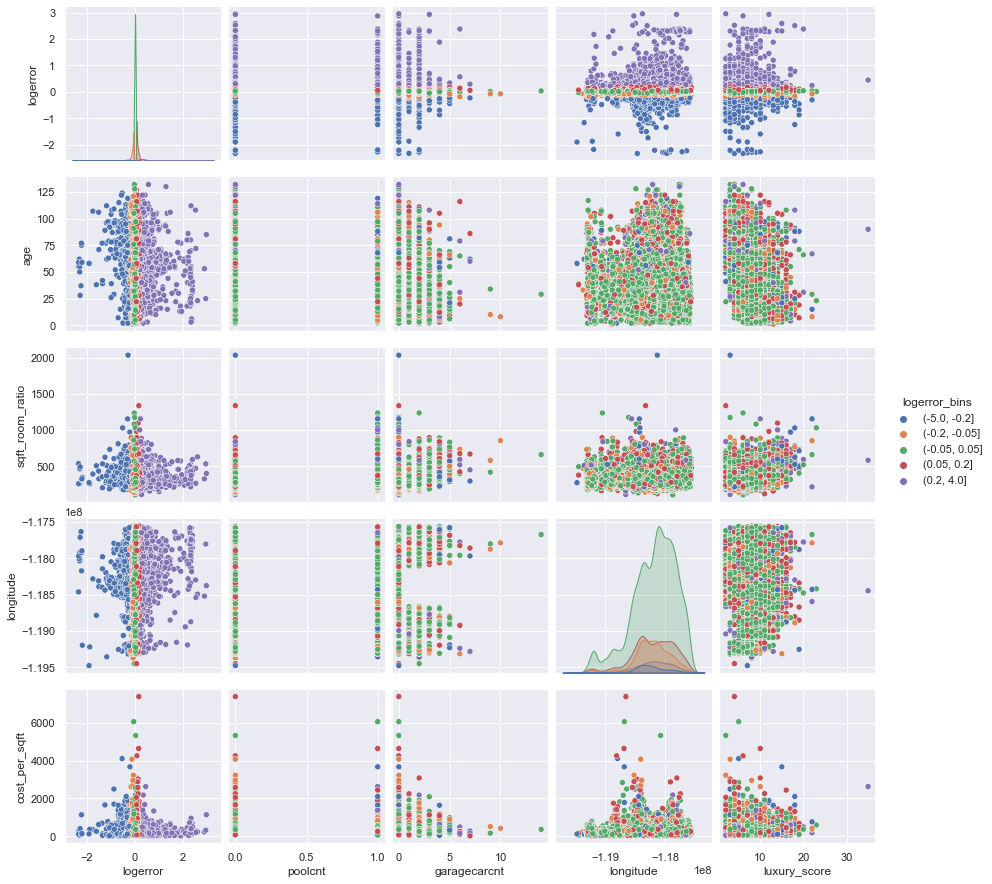

In [207]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'poolcnt', 'garagecarcnt', 'latitude', 
                       'luxury_score'],
             y_vars = ['logerror', 'age', 'sqft_room_ratio', 'longitude', 'cost_per_sqft'])

    1. appears that larger longitude(further west) correllates to lower error
    2. cost per sq ft is lower there is correlation to higher error
    3.lower sq ft room ratio points to higher error
    4. age is interesting, looks like there are periods of years that have higher error
    5. pockets of higher cost per sqft at diff longitudes

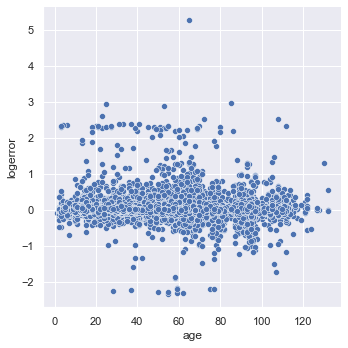

In [208]:
sns.relplot(x=train.age, y=df.logerror, data=train, palette='deep', legend='auto', kind='scatter', height=5, aspect=1, facet_kws=None, units=None, )

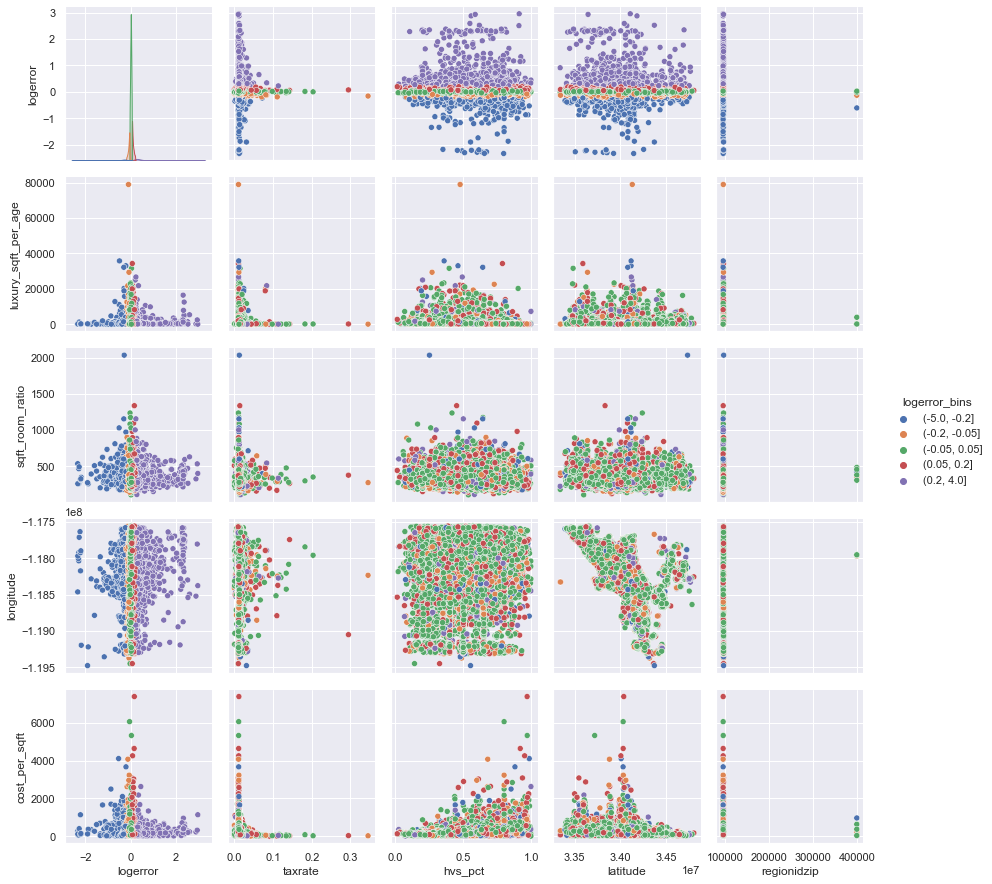

In [209]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'taxrate', 'hvs_pct', 'latitude', 
                       'regionidzip'],
             y_vars = ['logerror', 'luxury_sqft_per_age', 'sqft_room_ratio', 'longitude', 'cost_per_sqft'])

    1. log error and tax rate are correllated, lower has greater error
    2. log error and hvs pct have an interesting chart
    3. lower log error towards the southern and northern latitudes
    4. plot of lat long is awesome, la area map!

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52119 entries, 0 to 52318
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   parcelid                             52119 non-null  int64  
 1   bathrooms                            52119 non-null  int32  
 2   bedrooms                             52119 non-null  int32  
 3   sqft                                 52119 non-null  int32  
 4   fips                                 52119 non-null  object 
 5   fullbathcnt                          52119 non-null  float64
 6   garagecarcnt                         52119 non-null  int32  
 7   latitude                             52119 non-null  float64
 8   longitude                            52119 non-null  float64
 9   lotsizesquarefeet                    52119 non-null  float64
 10  poolcnt                              52119 non-null  int32  
 11  regionidcity                

In [ ]:
sns.catplot(x="latitude", y="longitude", hue='logerror_bins', data=train)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52119 entries, 0 to 52318
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   parcelid                             52119 non-null  int64  
 1   bathrooms                            52119 non-null  int32  
 2   bedrooms                             52119 non-null  int32  
 3   sqft                                 52119 non-null  int32  
 4   fips                                 52119 non-null  object 
 5   fullbathcnt                          52119 non-null  float64
 6   garagecarcnt                         52119 non-null  int32  
 7   latitude                             52119 non-null  float64
 8   longitude                            52119 non-null  float64
 9   lotsizesquarefeet                    52119 non-null  float64
 10  poolcnt                              52119 non-null  int32  
 11  regionidcity                

In [109]:
df.airconditioningdesc.value_counts()

None         38684
Central      11852
Yes           1567
Wall Unit       16
Name: airconditioningdesc, dtype: int64

In [110]:
df.airconditioningdesc.isna().value_counts()

False    52119
Name: airconditioningdesc, dtype: int64

In [111]:
df.poolcnt.value_counts()

0    41065
1    11054
Name: poolcnt, dtype: int64

In [112]:
df.poolcnt.isna().value_counts()

False    52119
Name: poolcnt, dtype: int64

In [113]:
df.garagecarcnt.value_counts()

0     34235
2     14750
1      2195
3       618
4       251
5        45
6        12
7         3
10        3
8         2
9         2
11        1
13        1
14        1
Name: garagecarcnt, dtype: int64

In [114]:
# df=df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "sqft","taxvaluedollarcnt": "home_value"})

In [115]:
# #filled null/Nonetype with 'None' or '0'
# df.heatingorsystemdesc= df.heatingorsystemdesc.fillna('None')
# df.airconditioningdesc= df.airconditioningdesc.fillna('None')
# df.poolcnt= df.poolcnt.fillna('0')
# df.garagecarcnt = df.garagecarcnt.fillna('0')
# df.isna().sum()

In [116]:
# #need to drop rows where bedrooms = 0
# df[df.bedrooms == 0]
# df = df[df.bedrooms != 0]

In [117]:
# #feature engineering
# df['home_value_structure_tax_difference']= (df['home_value']-df['structuretaxvaluedollarcnt'])
# df.home_value_structure_tax_difference.describe()

In [118]:
# #feature engineering
# df['hvs_pct'] = (df['home_value_structure_tax_difference']/df['home_value'])

In [119]:
# #will use the value to impute missing structuretaxvaluedollarcnt
# df.hvs_pct.mean()

In [120]:
# df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(df['home_value']*df['hvs_pct'].mean())
# df[df['structuretaxvaluedollarcnt'].isna()]

In [121]:
# df[df.taxamount.isna()]

In [122]:
# #feature engineering
# df['taxrate'] = (df['taxamount']/df['home_value'])
# df.taxrate.mean()

In [123]:
# #impute 4 missing values for taxamount using mean taxrate of feature engineering
# df.taxamount = df.taxamount.fillna(df['home_value']*df['taxrate'].mean())
# df.taxamount.isna().sum()

In [124]:
# # df[df.bathrooms == 0]
# df.bathrooms.mean()

In [125]:
# #impute null 0 bathrooms with mean
# df.bathrooms = df.bathrooms.fillna(2.0)

In [126]:
# df.fullbathcnt= df.fullbathcnt.fillna(df.bathrooms)

In [127]:
df.fullbathcnt.isna().sum()

0

In [128]:
# df.bathrooms.replace(0, 2, inplace=True)

In [129]:
# df[df.bathrooms == 0]

In [130]:
# #impute null regionidcity with mode
# df.regionidcity.value_counts()

In [131]:
# df['regionidcity'] = df.regionidcity.fillna(12447)
# df.regionidcity.isna().sum()

In [132]:
# df.home_value_structure_tax_difference.isna().sum()

In [133]:
# #impute missing values with below
# df.home_value_structure_tax_difference = df.home_value_structure_tax_difference.fillna(df['home_value']-df['structuretaxvaluedollarcnt'])
# df.home_value_structure_tax_difference.isna().sum()

In [134]:
# df.hvs_pct.isna().sum()

In [135]:
# # impute missing values with below
# df.hvs_pct = df.hvs_pct.fillna(df['home_value_structure_tax_difference']/df['home_value'])
# df.hvs_pct.isna().sum()

In [136]:
# df.hvs_pct.isna().sum()

In [137]:
# df.isna().sum()

In [138]:
# df[df.yearbuilt.isna()]

In [139]:
#impute nulls with mean year built
# df.yearbuilt = df.yearbuilt.fillna(df['yearbuilt'].mean())
# df.yearbuilt.isna().sum()

In [140]:
# df.yearbuilt.mode()

In [141]:
# df.regionidzip.mode()

In [142]:
# #impute nulls with mode of regionidzip
# df.regionidzip = df.regionidzip.fillna(97_319)
# df.regionidzip.isna().sum()

In [143]:
# df.regionidcity.mode()

In [144]:
# df.lotsizesquarefeet.median()

In [145]:
# #replace nulls with median lot size
# df.lotsizesquarefeet = df.lotsizesquarefeet.fillna(df.lotsizesquarefeet.median())
# df.lotsizesquarefeet.isna().sum()

In [146]:
#impute fullbathcnt with value from df.bathrooms
# df.fullbathcnt = df.fullbathcnt.fillna(df.bathrooms)

In [147]:
# df.isna().sum()

In [148]:
#drop remaining handful of nulls
# df = df.dropna()

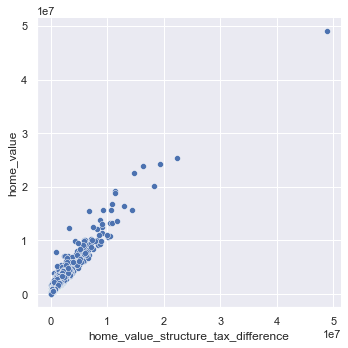

In [210]:
sns.relplot(x=df.home_value_structure_tax_difference, y=df.home_value, data=df, palette='deep', legend='auto', kind='scatter', height=5, aspect=1, facet_kws=None, units=None, )

In [ ]:
# round(df.dropna().shape[0] / df.shape[0], 4)

In [150]:
sns.set_theme()

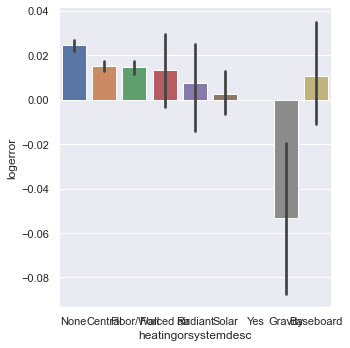

In [212]:
sns.catplot(data=df, kind="bar", x="heatingorsystemdesc", y="logerror")

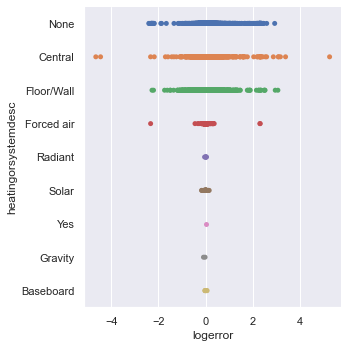

In [153]:
sns.catplot(x="logerror", y="heatingorsystemdesc", jitter=False, data=df)

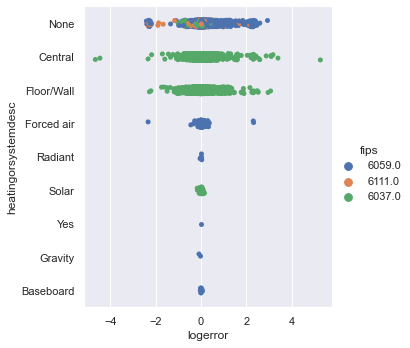

In [192]:

sns.catplot(x="logerror", y="heatingorsystemdesc", hue='fips', data=df)

<AxesSubplot:xlabel='logerror', ylabel='heatingorsystemdesc'>

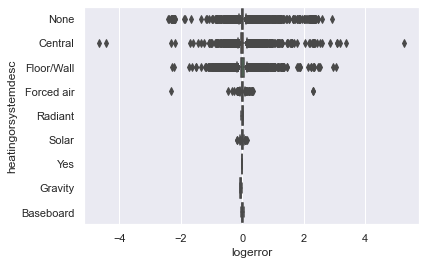

In [191]:

sns.boxplot(x="logerror", y="heatingorsystemdesc", data=df)

In [ ]:
# print("LA County Verified: ", df[df.fips==6037]['fips'].count() == df.LA.sum())
# print("Orange County Verified: ", df[df.fips==6059]['fips'].count() == df.Orange.sum())
# print("Ventura County Verified: ", df[df.fips==6111]['fips'].count() == df.Ventura.sum())

In [ ]:
#feature engineering
# df['age'] = 2017 - df.yearbuilt

In [ ]:
#feature engineering
#luxuryscore will be counts for pool, garage, ac, number of bathrooms and bedrooms
# df['luxury_score'] = (df['poolcnt']+df['garagecarcnt']+df['bedrooms']+df['bathrooms']+df['airconditioning_encoded'])

In [ ]:
# mapping = {"None" : "0",
#                      "Central" : "2",
#                      "Yes" : "1",
#                      "Wall Unit" : "1",
#                      }
# print(mapping)

In [156]:
# def get_counties():
#     '''
#     This function will create dummy variables out of the original fips column. 
#     And return a dataframe with all of the original columns except regionidcounty.
#     We will keep fips column for data validation after making changes. 
#     New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
#     The fips ids are renamed to be the name of the county each represents. 
#     '''
#     # create dummy vars of fips id
#     county_df = pd.get_dummies(df.fips)
#     # rename columns by actual county name
#     county_df.columns = ['LA', 'Orange', 'Ventura']
#     # concatenate the dataframe with the 3 county columns to the original dataframe
#     df_dummies = pd.concat([df, county_df], axis = 1)
#     # drop regionidcounty and fips columns
#     df_dummies = df_dummies.drop(columns = ['regionidcounty'])
#     return df_dummies

In [157]:
# df = get_counties()
# df.head().T

,0,1,2,3,4
parcelid,14297519,17052889,14186244,12177905,12095076
bathrooms,3,1,2,3,3
bedrooms,4,2,3,4,4
sqft,3100,1465,1243,2376,2962
fips,6059.0,6111.0,6059.0,6037.0,6037.0
fullbathcnt,3.00,1.00,2.00,3.00,3.00
garagecarcnt,2,1,2,0,0
latitude,"33,634,931.00","34,449,266.00","33,886,168.00","34,245,180.00","34,145,202.00"
longitude,"-117,869,207.00","-119,281,531.00","-117,823,170.00","-118,240,722.00","-118,179,824.00"
lotsizesquarefeet,"4,506.00","12,647.00","8,432.00","13,038.00","63,000.00"


In [ ]:
# df['airconditioning_encoded'] = df['airconditioningdesc'].map(mapping)

In [ ]:
# def optimize_types(df):
#     # Convert some columns to integers
#     # fips, yearbuilt, and bedrooms can be integers
#     df["fips"] = df["fips"].astype(str)
#     df["yearbuilt"] = df["yearbuilt"].astype(int)
#     df["bedrooms"] = df["bedrooms"].astype(int)
#     df["bathrooms"] = df["bathrooms"].astype(int)
#     df["home_value"] = df["home_value"].astype(int)
#     df["garagecarcnt"] = df["garagecarcnt"].astype(int)
#     df["poolcnt"] = df["poolcnt"].astype(int)
# #     df["heatingorsystemdesc"] = df["heatingorsystemdesc"].astype(int)
#     df["airconditioning_encoded"] = df["airconditioning_encoded"].astype(int)
    
    
    
#     df["sqft"] = df["sqft"].astype(int)
    
    
    
    
#     return df

In [ ]:
# df = optimize_types(df)

In [ ]:
#feature engineering luxury score/age*sqft
# df['luxury_sqft_per_age']= (df['luxury_score']*df['sqft']/df['age'])

In [ ]:
# def get_counties():
#     '''
#     This function will create dummy variables out of the original fips column. 
#     And return a dataframe with all of the original columns except regionidcounty.
#     We will keep fips column for data validation after making changes. 
#     New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
#     The fips ids are renamed to be the name of the county each represents. 
#     '''
#     # create dummy vars of fips id
#     county_df = pd.get_dummies(df.fips)
#     # rename columns by actual county name
#     county_df.columns = ['LA', 'Orange', 'Ventura']
#     # concatenate the dataframe with the 3 county columns to the original dataframe
#     df_dummies = pd.concat([df, county_df], axis = 1)
#     # drop regionidcounty and fips columns
#     df_dummies = df_dummies.drop(columns = ['regionidcounty'])
#     return df_dummies

Mall customers

Question 1

Acquire data from the customers table in the mall_customers database.

In [ ]:

#Define a query for the mall dataset
mall_query = '''
             SELECT *
             FROM customers
             '''

In [ ]:
#Create the url to access the database
mall_database = 'mall_customers'

mall_url = wr.get_db_url(mall_database)

In [ ]:
#Read in the dataset
mall_df = pd.read_sql(mall_query, mall_url)

mall_df.head()

In [ ]:
# Question 2
# Summarize the data (include distributions and descriptive statistics).

In [ ]:
#Visualize distribution of target variable
plt.hist(mall_df['spending_score'])

In [ ]:
#Descriptive statistics of numerical columns
mall_df.describe().T

In [ ]:
mall_df.isna().sum()

In [ ]:
#See the quantiles for age
mall_df['age'].quantile([0.25, 0.75])

In [ ]:
#Store the quantiles in variables
age_q1, age_q3 = mall_df['age'].quantile([0.25, 0.75])

In [ ]:
#Calculate the IQR
age_iqr = age_q3 - age_q1

age_iqr

In [ ]:
#Calculate upper and lower bounds based on a k value of 1.5
age_upper = age_q3 + (age_iqr * 1.5)
age_lower = age_q1 - (age_iqr * 1.5)

age_upper, age_lower

In [ ]:
#Check for outliers in the age column
mall_df[mall_df['age'] > age_upper]

In [ ]:
# Question 4
# Split data into train, validate, and test.

In [ ]:
#Split my data into three subsets
seed = 42

mall_train, test_val = train_test_split(mall_df, train_size=0.7,
                                   random_state=seed)

mall_test, mall_val = train_test_split(test_val, train_size=0.5,
                                       random_state=seed)

mall_train.shape, mall_val.shape, mall_test.shape

In [ ]:
# Question 5
# Encode categorical columns using a one hot encoder (pd.get_dummies).

In [ ]:
#Check get_dummies works as expected on my training data
pd.get_dummies(mall_train)

In [ ]:
#Create the dataframe with dummies for gender and drop redundant column
mall_train = pd.get_dummies(mall_train)

mall_train.drop(columns=['gender_Male'], inplace=True)

mall_train.head()

In [ ]:
# Question 6
# Handle missing values.

In [ ]:
#Check for missing values
mall_train.info()

In [ ]:
# Question 7
# Scaling

In [ ]:
#Initialize the scaler and fit/transform a couple columns in my training data
mms = MinMaxScaler()

mall_train[['age', 'annual_income']] = mms.fit_transform(mall_train[['age',
                                                                     'annual_income']])

mall_train.head()